<a href="https://colab.research.google.com/github/Marcellinus08/Deep-Learning/blob/main/Deteksi_Sarkasme_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Library

In [1]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve


Load dan Preprocessing

In [2]:
# Load JSON
df = pd.read_json('https://raw.githubusercontent.com/farrelrassya/teachingMLDL/refs/heads/main/02.%20Deep%20Learning/06.%20Week%206/Datasets/DeteksiSarkasme.json', lines=True)

# Kolom yang digunakan: 'headline' (fitur), 'is_sarcastic' (label)
texts = df['headline'].astype(str).values
labels = df['is_sarcastic'].values

# Text cleaning
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text

texts = [clean_text(t) for t in texts]

# Tokenisasi
tokenizer = Tokenizer(num_words=30000, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
X = pad_sequences(sequences, maxlen=500)
y = labels


Split Data

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Hyperparameter Tuning dengan Keras Tuner

In [4]:
!pip install -q -U keras-tuner
import keras_tuner as kt

def build_model(hp):
    model = Sequential()
    model.add(Embedding(30000, hp.Choice('embedding_dim', [64, 128, 256]), input_length=500))

    for i in range(hp.Int('rnn_layers', 1, 2)):
        model.add(SimpleRNN(
            units=hp.Int(f'rnn_units_{i}', 32, 128, step=32),
            return_sequences=(i < 1)
        ))
        model.add(Dropout(hp.Float(f'dropout_{i}', 0.2, 0.5, step=0.1)))

    model.add(Dense(hp.Int('dense_units', 32, 128, step=32), activation='relu'))
    model.add(Dropout(hp.Float('dropout_dense', 0.2, 0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=hp.Choice('optimizer', ['adam', 'rmsprop']),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 6.3 MB/s eta 0:00:00


 Konfigurasi Terbaik

In [5]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='deep_rnn_tuner_ds3',
    project_name='sarkasme'
)

tuner.search(X_train, y_train, epochs=5, validation_split=0.2, verbose=1)

best_hps = tuner.get_best_hyperparameters(1)[0]

print("=== Best Configuration ===")
print(f"Best Embedding Dim : {best_hps.get('embedding_dim')}")
print(f"Best RNN Units     : {[best_hps.get(f'rnn_units_{i}') for i in range(best_hps.get('rnn_layers'))]}")
print(f"Best Dense Units   : {best_hps.get('dense_units')}")
print(f"Best Optimizer     : {best_hps.get('optimizer')}")


Trial 5 Complete [00h 00m 01s]

Best val_accuracy So Far: 0.8488535284996033
Total elapsed time: 00h 12m 28s
=== Best Configuration ===
Best Embedding Dim : 256
Best RNN Units     : [64, 32]
Best Dense Units   : 128
Best Optimizer     : rmsprop


Training Ulang Model Terbaik

In [6]:
model = tuner.hypermodel.build(best_hps)

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=128,
    validation_split=0.2,
    verbose=1
)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


134/134 ━━━━━━━━━━━━━━━━━━━━ 40s 220ms/step - accuracy: 0.5610 - loss: 0.6837 - val_accuracy: 0.7082 - val_loss: 0.5875
Epoch 2/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 28s 178ms/step - accuracy: 0.8145 - loss: 0.4209 - val_accuracy: 0.8379 - val_loss: 0.3701
Epoch 3/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 51s 254ms/step - accuracy: 0.9044 - loss: 0.2509 - val_accuracy: 0.8334 - val_loss: 0.4186
Epoch 4/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 28s 210ms/step - accuracy: 0.9503 - loss: 0.1402 - val_accuracy: 0.8311 - val_loss: 0.5067
Epoch 5/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 36s 171ms/step - accuracy: 0.9580 - loss: 0.1175 - val_accuracy: 0.8376 - val_loss: 0.6203
Epoch 6/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 39s 158ms/step - accuracy: 0.9867 - loss: 0.0393 - val_accuracy: 0.8105 - val_loss: 0.9142
Epoch 7/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 17s 129ms/step - accuracy: 0.9958 - loss: 0.0140 - val_accuracy: 0.8343 - val_loss: 0.8999
Epoch 8/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 20s 127ms/step - accuracy: 0.9972 - loss: 0.0092 - val

Evaluasi

In [7]:
# Prediksi
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Evaluasi
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_probs)

print("=== Evaluation Metrics ===")
print(f"Akurasi  : {acc:.4f}")
print(f"Presisi  : {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")


167/167 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step
=== Evaluation Metrics ===
Akurasi  : 0.8160
Presisi  : 0.8396
Recall   : 0.7182
F1 Score : 0.7742
AUC      : 0.8910


Visualisasi (Accuracy, Loss)

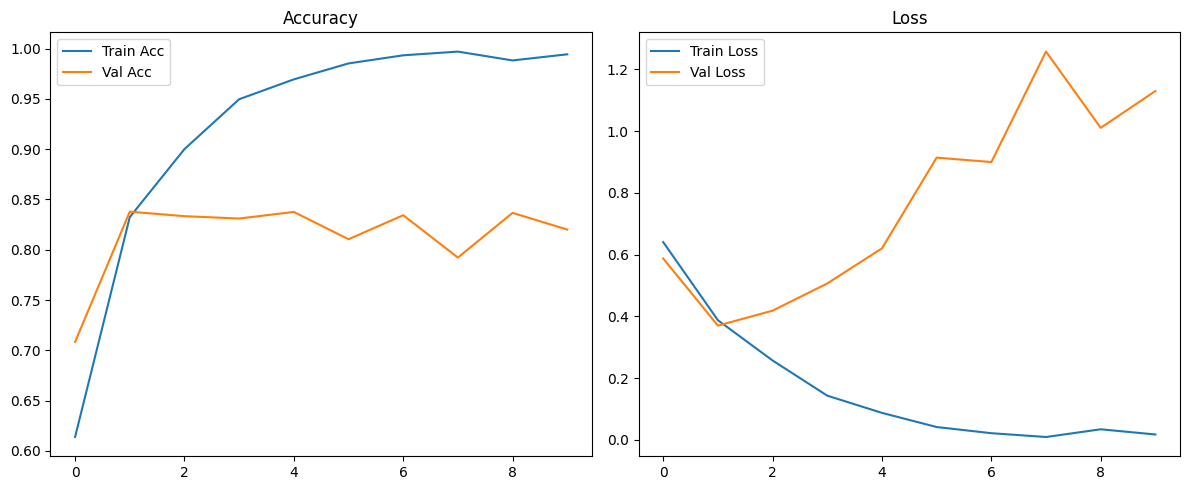

In [8]:
# Visualisasi akurasi & loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.tight_layout()
plt.show()


ROC Curve

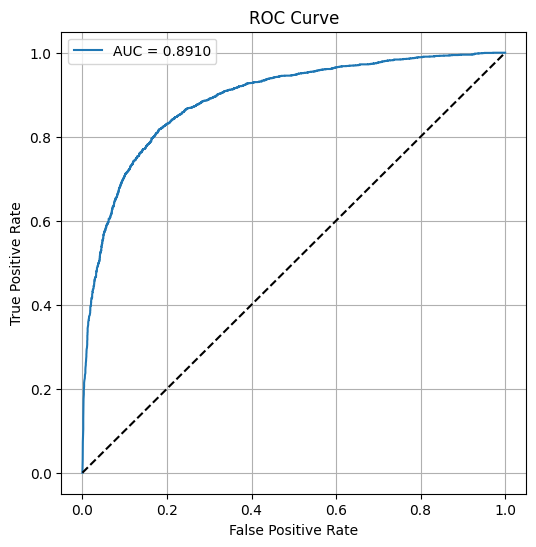

In [9]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()